In [11]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import latexify as lt
import os
#from thinkdsp import read_json
import scipy
import speechpy
#LOSO Validation
loo = LeaveOneOut()
import tsfel
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import pickle

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
#the file where all data is arranged.
data = pd.read_csv("data_FVC_Cloth.csv")
print("Total Data Points = ",len(data))
data.head(15)

Total Data Points =  25


,Name,Filename,rPEF,rFEV1,rFVC,rRatio,gPEF,gFEV1,gFVC,gRatio,Sex,LH
0,Maithili01,Maithili01.FVC_C.2b677eno.wav,1.66,0.08,2.67,2.996255,4.39,2.12,2.86,74.125874,F,Y
1,Rahul01,Rahul01.FVC_C.2b8ks79f.wav,1.02,0.03,1.21,2.479339,7.00,3.43,3.43,100.000000,M,Y
2,ShikhaD01,ShikhaD01.FVC_C.2b6c0d7k.wav,2.13,0.09,3.27,2.752294,4.50,1.92,2.07,92.753623,F,Y
3,Vignesh01,Vignesh01.FVC_C.2bb95nom.wav,3.11,0.11,2.97,3.703704,7.12,3.16,3.28,96.341463,M,Y
4,Yash01,Yash01.FVC_C.2b8n937i.wav,1.24,0.10,1.24,8.064516,7.81,2.96,2.96,100.000000,M,Y
5,Sandra01,Sandra01.FVC_C.2bdaignt.wav,1.03,0.06,1.04,5.769231,4.07,2.59,2.67,97.003745,F,Y
6,Hatim01,Hatim01.FVC_C.2be1a9u6.wav,2.03,0.07,2.40,2.916667,2.52,0.61,2.73,22.344322,M,Y
7,Maithili02,Maithili02.FVC_C.2b676jbf.wav,2.08,0.12,2.67,4.494382,4.39,2.12,2.86,74.125874,F,Y
8,Kaushal01,Kaushal01.FVC_C.06.LCL.2bldi9ts.wav,2.01,0.08,2.77,2.888087,8.42,3.36,3.60,93.333333,M,Y
9,Kaushal02,Kaushal02.FVC_C.06.LCL.2bldi9ts.wav,1.29,0.06,2.60,2.307692,8.42,3.36,3.60,93.333333,M,Y


In [61]:
#load time series feature
with open('ts-fel-cloth.pickle', 'rb') as handle:
    ts_features = pickle.load(handle)
    
with open('ts-fel-cloth-Envelope.pickle', 'rb') as handle:
    ts_features_envelope = pickle.load(handle)

In [62]:
def get_features(filepath, lungParam):
    
    #use the below line if the data is in json
    #wave = read_json(filepath=filepath)
    
    #use the below line if the data is in wav
    ys, fs = librosa.load(filepath)
    
    if lungParam == 'FEV1':
        print("FEV1 is the param. Audio signal will be clipped to peak only")
        peakIndex = np.where(ys == ys.max())[0][0]
        ys = ys[0:peakIndex+1];

    ys = speechpy.processing.preemphasis(ys, cof=0.98)
    
    
    #staching frames
    frames = speechpy.processing.stack_frames(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01, filter=lambda x: np.ones((x,)),zero_padding=True)

    '''
    *MFCC*
    We calculate the mean value for every single coefficient for MFCC. It means that for every audio file
    we have a vector of size 13 elements (For MFCC with 13 coefficients).
    
    *MelSpectogram*
    We calculate the mean value for every single mel band. It means that for every audio file
    we have a vector of size 128 elements (For 128 Mel bands).
    
    *Chromagram*
    12 Chroma Bins are produced by default. Similar to above, we  have a vector of size 12 for each audio file
    
    '''
    
   
    #speechfy features begins
    #extracting power spectrum
    power_spectrum = np.mean(speechpy.processing.power_spectrum(frames, fft_points=512), axis=0)
    #print(power_spectrum.shape)
    
    mfcc = speechpy.feature.mfcc(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfcc_cmvn = np.mean(speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True), axis=0)
    
    logenergy = speechpy.feature.lmfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    #logenergy_feature_cube = np.mean(speechpy.feature.extract_derivative_feature(logenergy), axis=0)
    logenergy = np.mean(logenergy, axis=0)
    
    mfe = speechpy.feature.mfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfe = np.mean(mfe[0],axis=0)
    
    
    #librosa feature begins
    stat_features = ts_features[filepath.split('/')[-1]]
    stat_features_envelope = ts_features_envelope[filepath.split('/')[-1]]
    mfc_coefficients = np.mean(librosa.feature.mfcc(y=ys, n_mfcc=13, sr=16000),axis=1)
    #print(mfc_coefficients.shape)
    
    
    melspectogram = np.mean(librosa.feature.melspectrogram(y=ys, sr=16000, n_mels=64, fmax=8000),axis=1)
    #print(melspectogram.shape)
    
    stft_spectrogram=np.abs(librosa.stft(ys))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=16000),axis=1)
    
    
    S, phase = librosa.magphase(librosa.stft(ys))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(S=S, sr=fs), axis=1) 
    zcr = np.mean(librosa.feature.zero_crossing_rate(ys)[0])
    
    
    '''
    We now have a vector of size 818 in the feature matrix. Later, we also add the approximate
    value of respective
    #lung parameter which changes the size of the vector to 154
    '''
    #feature_matrix_r = np.hstack((mfc_coefficients,melspectogram))
    #feature_matrix_r = np.hstack((melspectogram))
    feature_matrix_r = np.hstack((stat_features,stat_features_envelope,mfe, logenergy, mfcc_cmvn,power_spectrum,melspectogram,chromagram,spectral_rolloff,zcr))
    
    '''
    print("Stat Features = ",stat_features.shape)
    print("Stat Features (Envelope) = ",stat_features_envelope.shape)
    print("MFE Features = ",mfe.shape)
    print("Log Energy Features = ",logenergy.shape)
    print("MFCC CMVN Features = ",mfcc_cmvn.shape)
    print("Power Spectrum Features = ",power_spectrum.shape)
    print("Melspectogram Features = ",melspectogram.shape)
    print("Chroma Features = ",chromagram.shape)
    print("Spectral Roll Off  = ",spectral_rolloff.shape)
    print("ZCR Features = ", zcr.shape)
    '''
    
    #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
    
    #add the estimated param as a feature
    #feature_matrix = np.hstack((feature_matrix_r, FEV1values))
    return feature_matrix_r


def load_data(lungParam, sex, LH, file):
    '''
    feature: it is either 'FEV1', 'FVC' or 'PEF'
    '''
    data = pd.read_csv(file)
    
    if sex == 'M' or sex == 'F':
        data = data[data['Sex'] == sex]
    if LH == 'Y' or LH == 'N':
        data = data[data['LH'] == LH]
    
    
    #get the ground truth
    y=  np.array([i for i in data['g'+lungParam]])
    
    #prepare to store a lot of features in X
    X=[]
    count = 0
    for file in data['Filename']:
        features = get_features("SpiroMask-July2021/SmartMaskData/FVC/Cloth/"+file, lungParam)
        #print("Size of features = ",features.shape)
        X.append(features)
        count += 1
    X =  np.array(X)
    
    
    #add the estiamted lung param as a feature
    estiamtedValues = np.atleast_2d(data['r'+lungParam].to_numpy()).T
    X = np.hstack((X, estiamtedValues))
    # Return arrays to plug into sklearn's cross-validation algorithms
    return X, np.array(y)

## Using The Best Hyperparameters For FVC

In [64]:
#compare with base model

#load_data(param, Sex, Lung issue?)
X, Y = load_data('FEV1', 'A', 'Y', "data_FVC_Cloth.csv")
loo.get_n_splits(X)


print("Getting the performence of base model")
base = RandomForestRegressor(criterion='mae', n_estimators = 10, random_state = 42)
print("\n\n****Running Regression on PEF****")
min_pe= 0.99 
pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = base.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    #trueValue.append(y_test)
    #predictedValue.append(reg.predict(X_test))
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))



trueValue = []
predictedValue = []

print("\n\nGetting the performence of best random model")
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=10000, min_samples_split=2, min_samples_leaf=5, max_features='auto', max_depth=100)
print("\n\n****Running Regression on PEF****")
min_pe= 0.99 
pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    trueValue.append(y_test[0])
    predictedValue.append(reg.predict(X_test)[0])
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))
pd.DataFrame({'True':trueValue, 'Predicted':predictedValue}).to_csv("result-FEV1-Cloth-Not-Healthy.csv")

FEV1 is the param. Audio signal will be clipped to peak only
122 27221 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
156 34671 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
136 30271 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
139 30862 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
122 27155 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
117 26040 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
133 29645 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
115 25628 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
121 26882 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
129 28730 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
182 40403 441 220.0
FEV1 is the param. Audio signal will be clipped to peak only
213 47288 441 220.0
FEV1 is the param. Audio sig

In [76]:
#ML inits
regressor = RandomForestRegressor(n_estimators = 5000, random_state = 0)
#regressor = SVR(kernel = 'rbf', c=0.1)
#regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,max_depth = 50, alpha = 10, n_estimators = 50)
#regressor = Lasso(alpha = 0.01)
#regressor = Ridge(alpha=0.01)

In [43]:
X[0].shape

(1209,)

In [45]:
len(feature_names)

1209

<AxesSubplot:>

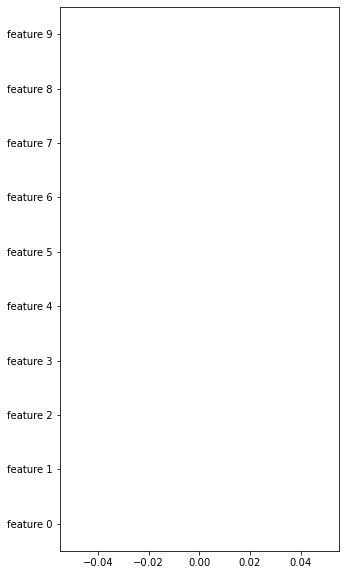

In [41]:
'''
0-389: Stat Features
390-779: Stat Features From Envelope
780-819: MFE Features
820-859: Log Energy Features
860-872: MFCC CMVN Features
873-1129: Power Spectrum Features
1130-1193: Melspectogram Features
1194-1205: Chroma Features
1206-1206: Spectral Roll off
1207-1207: ZCR
'''
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = reg.feature_importances_

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh', figsize=(5,10))

In [46]:
importances

array([0., 0., 0., ..., 0., 0., 0.])

Lets Plot the observed result

### Generate Final Plots For Paper

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


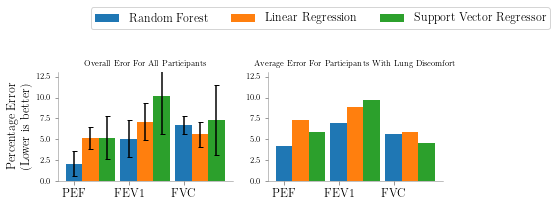

In [7]:
# plots to be manullly made using results from sheet
#N95 Mask

rf_pe= [2.1,5.1,6.7]
lr_pe = [5.2,7.1,5.6]
svr_pe = [5.2,10.2,7.3]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [4.2,7,5.65]
lr_pe_u = [7.3,8.85,5.85]
svr_pe_u = [5.85,9.75,4.55]


figname = 'revised-overall-error-n95'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


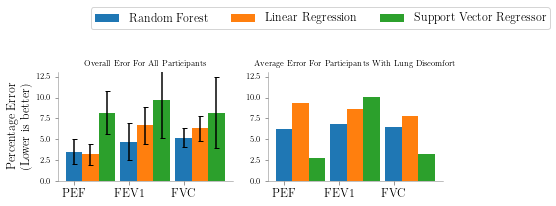

In [8]:
# plots to be manullly made using results from sheet
#Cloth Mask

rf_pe= [3.5,4.7,5.2]
lr_pe = [3.2,6.7,6.3]
svr_pe = [8.2,9.7,8.2]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [6.2,6.8,6.5]
lr_pe_u = [9.3,8.6,7.8]
svr_pe_u = [2.8,10.1,3.21]


figname = 'revised-overall-error-cloth'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
#ax[0].annotate(' Result For Cloth Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')